# Geospatio-temporal analysis 

In [1]:
import requests
import numpy as np
from scipy.optimize import curve_fit
import math
import pandas as pd
import boto3
import os
from boto3.dynamodb.conditions import Attr
from datetime import datetime, timedelta
from haversine import haversine
import folium
import branca.colormap
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

## Export env variables

In [2]:
with open("./app.env") as env_file:
    for env in env_file.read().splitlines():
        key, value = env.split('=')
        os.environ[key] = value

## Parameters

In [88]:
START_TIME = '2019-03-05 06:30:00'
BOUNDING_BOX = [(48.817625, 9.132240), (48.688466, 9.256419)] # NW, SE
DISTANCE_BINS = 500 # m
MAX_RANGE = 10000 # m
TARGET_GRID = 1000 # m

## Query data (Raw data source 1)

In [67]:
def add_10min(timestamp):
    """
    Adds 10 min to a timestamp string.
    
    Args:
        timestamp (str): Input timestamp time is added to
    Returns:
        str: Later timestamp
    """
    return (datetime.strptime(START_TIME, "%Y-%m-%d %H:%M:%S") + timedelta(minutes=10)).strftime("%Y-%m-%d %H:%M:%S")

INT_TS1 = add_10min(START_TIME)
INT_TS2 = add_10min(INT_TS1)

### DynamoDB query

In [5]:
dynamodb = boto3.resource('dynamodb', region_name='us-west-1', aws_access_key_id=os.environ['ACCESS_KEY'], aws_secret_access_key=os.environ['SECRET'])
table = dynamodb.Table('luftdaten')
response = table.scan(FilterExpression=Attr('timestamp').contains(START_TIME[:15]) | 
                      Attr('timestamp').contains(INT_TS1[:15]) | 
                      Attr('timestamp').contains(INT_TS2[:15]),
                      ProjectionExpression='sensordatavalues, #t, sensor.id, #l.longitude, #l.latitude, #l.altitude',
                      ExpressionAttributeNames = {'#t': 'timestamp', '#l': 'location'})
response_items = response['Items']

i = 0
while 'LastEvaluatedKey' in response:
    response = table.scan(ExclusiveStartKey=response['LastEvaluatedKey'],
                          FilterExpression=Attr('timestamp').contains(START_TIME[:15]) | 
                          Attr('timestamp').contains(INT_TS1[:15]) | 
                          Attr('timestamp').contains(INT_TS2[:15]),
                          ProjectionExpression='sensordatavalues, #t, sensor.id, #l.longitude, #l.latitude, #l.altitude',
                          ExpressionAttributeNames = {'#t': 'timestamp', '#l': 'location'})
    response_items.extend(response['Items'])
    #i += 1
    #if i == 10:
        #break

## Download live data (Raw data source 2)

In [68]:
#API = 'http://api.luftdaten.info/static/v1/data.json'


#def filter_pm_data(json):
#    """
#    Filters only sensors with PM data.
#    Args:
#        json (list): List of sensor data jsons.
#    Returns (list): List of filtered sensor data jsons.
#    """
#    return [elem for elem in json if any([True if 'P1' in data.values() or 'P2' in data.values() else False for data in elem['sensordatavalues']]) and elem['location']['altitude']]

#res = requests.get(API).json()
#response_items = filter_pm_data(res)

## Data preprocessing

In [69]:
response_items[0]

{'id': 3713097502,
 'sampling_rate': None,
 'timestamp': '2019-05-23 14:21:52',
 'location': {'id': 5847,
  'latitude': '50.832',
  'longitude': '4.558',
  'altitude': '60.5',
  'country': 'BE',
  'exact_location': 0,
  'indoor': 0},
 'sensor': {'id': 11582,
  'pin': '1',
  'sensor_type': {'id': 14, 'name': 'SDS011', 'manufacturer': 'Nova Fitness'}},
 'sensordatavalues': [{'id': 7872990640, 'value': '2.93', 'value_type': 'P1'},
  {'id': 7872990641, 'value': '2.23', 'value_type': 'P2'}]}

In [70]:
len(response_items)

17598

In [72]:
def transform_pm_data(response_items):
    """
    Transforms pm data to the target format with time, location and pm values.
    
    Args:
        response_items (list): List of pm data from luftdaten.info.
        
    Returns (list): Transformed data.
    """
    pd_items = []
    for item in response_items:
        if (BOUNDING_BOX[0][1] < float(item['location']['longitude']) < BOUNDING_BOX[1][1]) and (BOUNDING_BOX[1][0] < float(item['location']['latitude']) < BOUNDING_BOX[0][0]):
            base_dict = {'latitude': float(item['location']['latitude']),
                         'longitude': float(item['location']['longitude']),
                         'altitude': float(item['location']['altitude']), 
                         'sensor_id': item['sensor']['id'], 
                         'timestamp': datetime.strptime(item['timestamp'], "%Y-%m-%d %H:%M:%S")}
            for sensorvalue in item['sensordatavalues']:
                if sensorvalue['value_type'] == 'P1' or sensorvalue['value_type'] == 'P2':
                    base_dict[sensorvalue['value_type']] = float(sensorvalue['value'])
            pd_items.append(base_dict)
    return pd_items

In [73]:
def filter_anomalous_pm(pm_data):
    """
    Filters out anomalous pm data:
    
    Args:
        pm_data (list): List of pm data.
        
    Returns (list): Filtered data.
    """
    return [data for data in pm_data if (data.get('P1') is not None and data.get('P1') < 1000) and (data.get('P2') is not None and data.get('P2') < 1000)]

In [74]:
base_df = pd.DataFrame(filter_anomalous_pm(transform_pm_data(response_items)))
base_df['id'] = base_df.index

In [75]:
base_df

,P1,P2,altitude,latitude,longitude,sensor_id,timestamp,id
0,2.40,1.85,289.3,48.632,9.344,17028,2019-05-23 14:21:58,0
1,5.07,2.50,328.8,48.624,9.316,12169,2019-05-23 14:22:23,1
2,2.00,1.90,343.6,48.602,9.340,13311,2019-05-23 14:22:43,2
3,1.40,1.30,335.5,48.698,9.310,24867,2019-05-23 14:22:59,3
4,4.83,1.80,265.7,48.672,9.374,458,2019-05-23 14:23:44,4
5,3.08,2.05,298.1,48.612,9.350,7114,2019-05-23 14:24:03,5
6,4.03,2.10,289.3,48.632,9.344,17028,2019-05-23 14:24:26,6
7,4.40,3.20,328.8,48.624,9.316,12169,2019-05-23 14:24:51,7
8,2.60,2.03,343.6,48.602,9.340,13311,2019-05-23 14:25:30,8
9,1.70,1.40,265.7,48.672,9.374,458,2019-05-23 14:26:12,9


## Measurements map

In [76]:
data_map = folium.Map(prefer_canvas=True)

def color_producer(pm_value):
    """
    Returns color to pm sensor values.
    
    Args:
        pm_value (float): PM sensor value.
        
    Returns (str): String with collor to fill in points.
    """
    if pm_value < 10:
        return 'green'
    elif 10 <= pm_value < 40:
        return 'orange'
    else:
        return 'red'

def plotDot(point):
    """
    Plots geospatial data containing lon and lats on a map.
    Args:
        point (pandas.DataFrame.Row): Data Frame row containing longitude and latitude of a point.
    """
    folium.CircleMarker(location=[point['latitude'], point['longitude']],
                        radius=2, color=color_producer(point['P1']), popup="P1: " + str(point['P1']) + " µg/m³").add_to(feature_group_p1)
    folium.CircleMarker(location=[point['latitude'], point['longitude']],
                        radius=2, color=color_producer(point['P2']), popup="P2: " + str(point['P2']) + " µg/m³").add_to(feature_group_p2)


colormap = branca.colormap.StepColormap(['green', 'orange', 'red', 'red'],
                           vmin=0., vmax=200.,
                           index=[0, 10, 40, 100, 200], caption='PM values [µg/m³]')
colormap.add_to(data_map)
feature_group_p1 = folium.FeatureGroup(name='P1')
feature_group_p2 = folium.FeatureGroup(name='P2', show=False)
base_df[:700].apply(plotDot, axis = 1)

feature_group_p1.add_to(data_map)
feature_group_p2.add_to(data_map)
folium.LayerControl().add_to(data_map)
data_map.fit_bounds(data_map.get_bounds())

data_map.save("./data/pm_measures_{0}_{1}_{2}.png")

data_map

## Create distance matrix

In [77]:
base_df['key'] = 1

In [78]:
merged_df = pd.merge(base_df, base_df, on='key')

In [79]:
dist_df = merged_df[['id_x', 'id_y']]
dist_df['dist'] = merged_df.apply(lambda row: haversine((row['latitude_x'], row['longitude_x']), (row['latitude_y'], row['longitude_y']))*1000, axis = 1)
dist_df['time_diff'] = merged_df.apply(lambda row: (row['timestamp_x'] - row['timestamp_y']).total_seconds(), axis=1)
dist_df['P1_diff'] = merged_df['P1_x'] - merged_df['P1_y']
dist_df['P2_diff'] = merged_df['P2_x'] - merged_df['P2_y']

In [80]:
dist_df

,id_x,id_y,dist,time_diff,P1_diff,P2_diff
0,0,0,0.000000,0.0,0.00,0.00
1,0,1,2241.868417,-25.0,-2.67,-0.65
2,0,2,3348.786422,-45.0,0.40,-0.05
3,0,3,7752.024810,-61.0,1.00,0.55
4,0,4,4963.823211,-106.0,-2.43,0.05
5,0,5,2267.208209,-125.0,-0.68,-0.20
6,0,6,0.000000,-148.0,-1.63,-0.25
7,0,7,2241.868417,-173.0,-2.00,-1.35
8,0,8,3348.786422,-212.0,-0.20,-0.18
9,0,9,4963.823211,-254.0,0.70,0.45


## Semivariance matrix

In [89]:
semivar_df = dist_df[['id_x', 'id_y', 'dist', 'time_diff']].query('id_x < id_y').query('dist < {0}'.format(MAX_RANGE))
semivar_df['P1_semivar'] = np.square(dist_df['P1_diff'])/2
semivar_df['P2_semivar'] = np.square(dist_df['P2_diff'])/2

In [90]:
semivar_df

,id_x,id_y,dist,time_diff,P1_semivar,P2_semivar
1,0,1,2241.868417,-25.0,3.56445,0.21125
2,0,2,3348.786422,-45.0,0.08000,0.00125
3,0,3,7752.024810,-61.0,0.50000,0.15125
4,0,4,4963.823211,-106.0,2.95245,0.00125
5,0,5,2267.208209,-125.0,0.23120,0.02000
6,0,6,0.000000,-148.0,1.32845,0.03125
7,0,7,2241.868417,-173.0,2.00000,0.91125
8,0,8,3348.786422,-212.0,0.02000,0.01620
9,0,9,4963.823211,-254.0,0.24500,0.10125
10,0,10,2267.208209,-272.0,0.00500,0.00845


## Semivariograms

In [91]:
variogram_dist_df = semivar_df[['dist', 'P1_semivar', 'P2_semivar']]
n_bins = np.ceil(variogram_dist_df['dist'].max()/DISTANCE_BINS)
variogram_dist_df['dist [m]'] = pd.cut(variogram_dist_df['dist'], n_bins, labels=np.arange(0, n_bins*DISTANCE_BINS, DISTANCE_BINS))

def calc_errors(pm_semivars):
    """
    Calculates the errors of the semivariance averageing.
    
    Args:
        pm_semivars (list): List of pm_semivars (pandas df column).
        
    Returns (float): Central limit theorem error.
    """
    return np.std(pm_semivars)/np.sqrt(len(pm_semivars))

variogram_df = variogram_dist_df.drop(['dist'], axis=1).groupby('dist [m]').agg(['mean', calc_errors])

Text(0, 0.5, 'PM [µg/m³]')

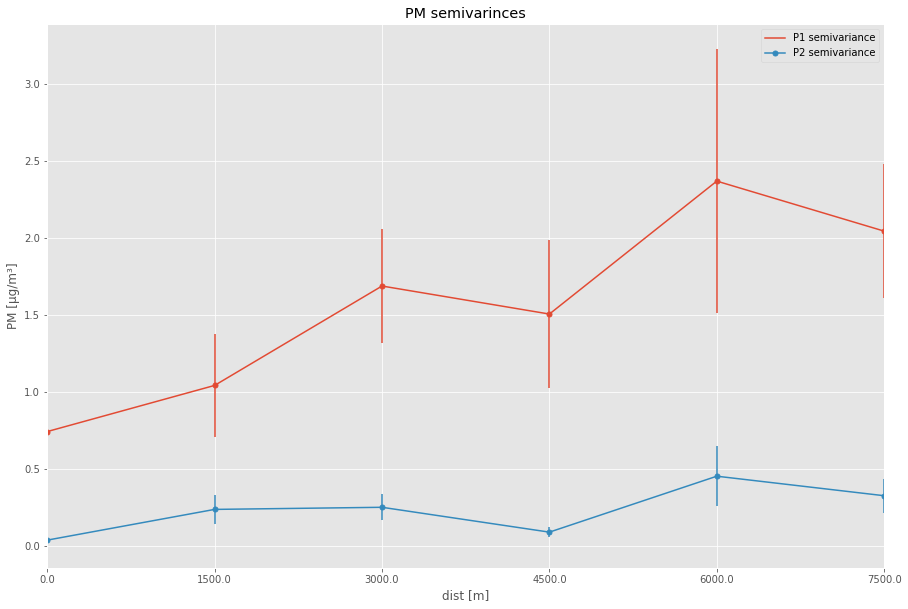

In [92]:
ax = variogram_df['P1_semivar']['mean'].plot(yerr=variogram_df['P1_semivar']['calc_errors'], marker='.', markersize=10,
                                             grid=True, label='P1 semivariance', legend=True, figsize=(15,10))
variogram_df['P2_semivar']['mean'].plot(yerr=variogram_df['P2_semivar']['calc_errors'], marker='.', markersize=10,
                                        grid=True, label='P2 semivariance', legend=True, ax=ax, figsize=(15,10))
ax.set_title('PM semivarinces')
ax.set_ylabel('PM [µg/m³]')

Text(0, 0.5, 'Number of points')

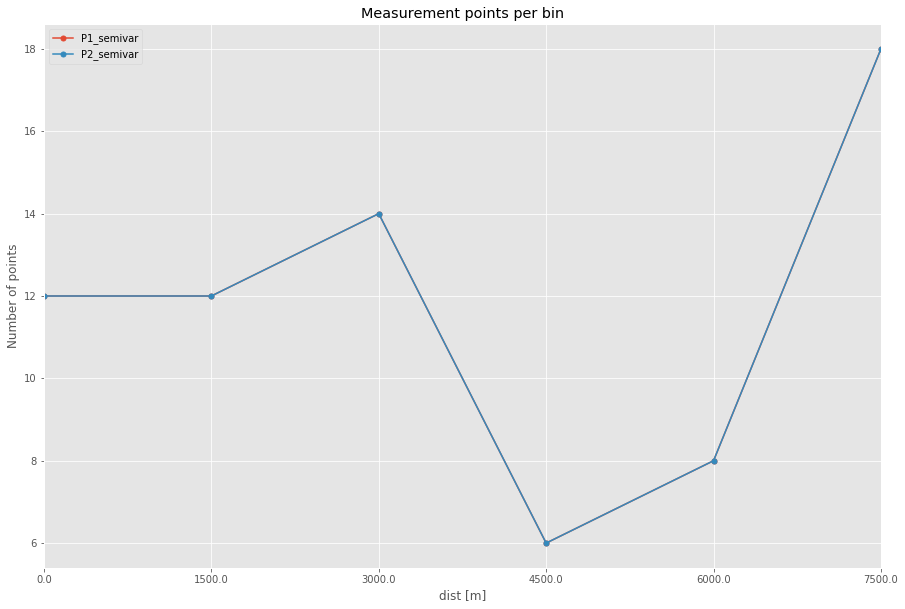

In [93]:
plot_count_df = variogram_dist_df.drop(['dist'], axis=1).groupby('dist [m]').count()
ax = plot_count_df.plot(marker='.', markersize=10, grid=True, figsize=(15,10))
ax.set_title('Measurement points per bin')
ax.set_ylabel('Number of points')

In [94]:
class Semivariogram():
    sill = 0
    range = 0
    nugget = 0
    
    def __init__(self):
        pass

    def spherical(self, h):
        if h == 0:
            y = 0
        if 0 < h <= self.range:
            y = self.nugget + (self.sill-self.nugget)*(3/2*h/self.range-1/2*(h/self.range)**3)
        if h > self.range:
            y = self.sill
        return y
    
    def spherical_fit(self, h, sill, nugget, range):
        self.sill = sill
        self.nugget = nugget
        self.range = range
        y = self.nugget + (self.sill-self.nugget)*(3/2*h/self.range-1/2*(h/self.range)**3)
        return y
    
    def exponential(self, h):
        if h == 0:
            y = 0
        if 0 < h:
            y = self.nugget + (self.sill-self.nugget)*(1-np.exp(-h/self.range))
        return y
    
    def exponential_fit(self, h, sill, nugget, range):
        self.sill = sill
        self.nugget = nugget
        self.range = range
        y = self.nugget + (self.sill-self.nugget)*(1-np.exp(-h/self.range))
        return y

In [119]:
semivariogram_sperical_p1 = Semivariogram()
semivariogram_sperical_p2 = Semivariogram()
semivariogram_exp_p1 = Semivariogram()
semivariogram_exp_p2 = Semivariogram()
semivario_df = variogram_df[np.array(variogram_df.index.values) <= MAX_RANGE]
popt_p1_sph, pcov_p1_sph = curve_fit(semivariogram_sperical_p1.spherical_fit, np.array(semivario_df.index.values), np.array(semivario_df['P1_semivar']['mean'].values), p0=[semivario_df['P1_semivar']['mean'].max(), semivario_df['P1_semivar']['mean'][0], semivario_df['P1_semivar']['mean'].idxmax()], bounds=(0,np.inf))
popt_p2_sph, pcov_p2_sph = curve_fit(semivariogram_sperical_p2.spherical_fit, np.array(semivario_df.index.values), np.array(semivario_df['P2_semivar']['mean'].values), p0=[semivario_df['P2_semivar']['mean'].max(), semivario_df['P2_semivar']['mean'][0], semivario_df['P2_semivar']['mean'].idxmax()], bounds=(0,np.inf))
popt_p1_exp, pcov_p1_exp = curve_fit(semivariogram_exp_p1.exponential_fit, np.array(semivario_df.index.values), np.array(semivario_df['P1_semivar']['mean'].values), p0=[semivario_df['P1_semivar']['mean'].max(), semivario_df['P1_semivar']['mean'][0], semivario_df['P1_semivar']['mean'].idxmax()], bounds=(0,np.inf))
popt_p2_exp, pcov_p2_exp = curve_fit(semivariogram_exp_p2.exponential_fit, np.array(semivario_df.index.values), np.array(semivario_df['P2_semivar']['mean'].values), p0=[semivario_df['P2_semivar']['mean'].max(), semivario_df['P2_semivar']['mean'][0], semivario_df['P2_semivar']['mean'].idxmax()], bounds=(0,np.inf))
print('P1_Sph: ', popt_p1_sph, '\n', pcov_p1_sph, end='\n')
print('P2_Sph: ', popt_p2_sph, '\n', pcov_p2_sph, end='\n')
print('P1_Exp: ', popt_p1_exp, '\n', pcov_p1_exp, end='\n')
print('P2_Exp: ', popt_p2_exp, '\n', pcov_p2_exp, end='\n')

P1_Sph:  [2.14027338e+00 7.02023930e-01 7.49247122e+03] 
 [[7.46244676e-02 7.83586790e-03 5.87459428e+02]
 [7.83586790e-03 6.35284104e-02 2.77167901e+02]
 [5.87459428e+02 2.77167901e+02 8.06371630e+06]]
P2_Sph:  [4.06813886e-01 8.59447027e-02 1.12615576e+04] 
 [[7.19083390e-01 4.51347018e-02 3.33597338e+04]
 [4.51347018e-02 1.56204608e-02 2.44835959e+03]
 [3.33597338e+04 2.44835959e+03 1.58158882e+09]]
P1_Exp:  [2.84092453e+00 7.02733432e-01 6.26196702e+03] 
 [[3.30573410e+00 2.24155838e-01 1.63090676e+04]
 [2.24155838e-01 8.19199505e-02 1.39321068e+03]
 [1.63090676e+04 1.39321068e+03 8.32318930e+07]]
P2_Exp:  [4.87876410e-01 7.36005822e-02 6.79534998e+03] 
 [[1.02076286e+00 6.08546605e-02 2.72366084e+04]
 [6.08546605e-02 1.84327998e-02 2.00233818e+03]
 [2.72366084e+04 2.00233818e+03 7.47657866e+08]]


In [125]:
def str_to_ntfs(string):
    """
    Transform a string to a ntfs valid string.
    
    Args:
        string (str): Input string.
        
    Returns (str): NTFS conform string.
    """
    mapping = [ ('[', ''), ('(', ''), (')', ''), (']', ''), (' ', ''), (',', '-'), (':', '-') ]
    for k, v in mapping:
        string = string.replace(k, v)
    return string

In [126]:
np.save('./data/semivariogramparams_popt_p1_sph_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), popt_p1_sph)
np.save('./data/semivariogramparams_pcov_p1_sph_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), pcov_p1_sph)
np.save('./data/semivariogramparams_popt_p2_sph_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), popt_p2_sph)
np.save('./data/semivariogramparams_pcov_p2_sph_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), pcov_p2_sph)
np.save('./data/semivariogramparams_popt_p1_exp_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), popt_p1_exp)
np.save('./data/semivariogramparams_pcov_p1_exp_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), pcov_p1_exp)
np.save('./data/semivariogramparams_popt_p2_exp_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), popt_p2_exp)
np.save('./data/semivariogramparams_pcov_p2_exp_{0}_{1}_{2}.npy'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), pcov_p2_exp)

Text(0, 0.5, 'PM [µg/m³]')

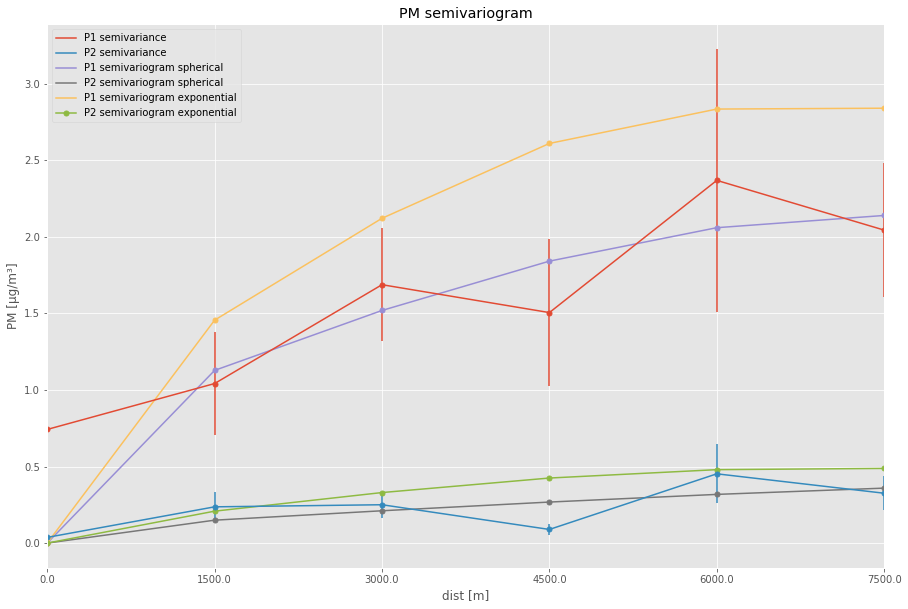

In [129]:
semivariogram_df = variogram_df
semivariogram_df['dist'] = semivariogram_df.index
semivariogram_df['fit_P1_sph'] = semivariogram_df.apply(lambda row: semivariogram_sperical_p1.spherical(float(row['dist'])), axis=1)
semivariogram_df['fit_P2_sph'] = semivariogram_df.apply(lambda row: semivariogram_sperical_p2.spherical(float(row['dist'])), axis=1)
semivariogram_df['fit_P1_exp'] = semivariogram_df.apply(lambda row: semivariogram_exp_p1.spherical(float(row['dist'])), axis=1)
semivariogram_df['fit_P2_exp'] = semivariogram_df.apply(lambda row: semivariogram_exp_p2.spherical(float(row['dist'])), axis=1)
semivariogram_df.to_csv('./data/semivariogram_{0}_{1}_{2}.csv'.format(str_to_ntfs(START_TIME), str_to_ntfs(str(BOUNDING_BOX)), str_to_ntfs(str(DISTANCE_BINS))), index=False)

ax = semivariogram_df['P1_semivar']['mean'].plot(yerr=semivariogram_df['P1_semivar']['calc_errors'], marker='.', markersize=10,
                                             grid=True, label='P1 semivariance', legend=True, figsize=(15,10))
semivariogram_df['P2_semivar']['mean'].plot(yerr=semivariogram_df['P2_semivar']['calc_errors'], marker='.', markersize=10,
                                        grid=True, label='P2 semivariance', legend=True, ax=ax, figsize=(15,10))
semivariogram_df['fit_P1_sph'].plot(marker='.', markersize=10,
                                grid=True, label='P1 semivariogram spherical', legend=True, ax=ax, figsize=(15,10))
semivariogram_df['fit_P2_sph'].plot(marker='.', markersize=10,
                                grid=True, label='P2 semivariogram spherical', legend=True, ax=ax, figsize=(15,10))
semivariogram_df['fit_P1_exp'].plot(marker='.', markersize=10,
                                grid=True, label='P1 semivariogram exponential', legend=True, ax=ax, figsize=(15,10))
semivariogram_df['fit_P2_exp'].plot(marker='.', markersize=10,
                                grid=True, label='P2 semivariogram exponential', legend=True, ax=ax, figsize=(15,10))
ax.set_title('PM semivariogram')
ax.set_ylabel('PM [µg/m³]')

## Kriging

In [130]:
def calculate_spatial_point_in_distance_and_bearing(start_point, distance, bearing):
    """
    Calculates a destination in distance from given location in bearing direction.
    
    Args:
        start_point (tuple): Spatial start point in degree in lat/lon order.
        distance (float): Distance to destination in metres.
        bearing (float): Bearing to destination point in degree.
        
    Returns (tuple): Destination point in lat/lon order.
    """
    R = 6378.1 #Radius of the Earth in km
    brng = math.radians(bearing) #Bearing converted to radians.
    d = distance/1000 #Distance in km
    start_lat = start_point[0]
    start_lon = start_point[1]

    lat1 = math.radians(start_lat) #Current lat point converted to radians
    lon1 = math.radians(start_lon) #Current long point converted to radians

    lat2 = math.asin( math.sin(lat1)*math.cos(d/R) +
         math.cos(lat1)*math.sin(d/R)*math.cos(brng))

    lon2 = lon1 + math.atan2(math.sin(brng)*math.sin(d/R)*math.cos(lat1),
                 math.cos(d/R)-math.sin(lat1)*math.sin(lat2))

    lat2 = math.degrees(lat2)
    lon2 = math.degrees(lon2)

    return (round(lat2, 5), round(lon2, 5))

def calculate_spatial_grid(bounding_box, distance):
    """
    Calculates an equidistant spatial grid in given bounding box.
    
    Args:
        bounding_box (list): Bounding box given as list of NW and SE tuples in lat/lon order.
        distance (float): Distance between grid points in metres.
        
    Returns (list): List of grid points in lat/lon order.
    """
    current_column_point = bounding_box[0]
    current_row_point = bounding_box[0]
    grid = []
    for i in range(int(haversine(bounding_box[0], (bounding_box[0][0], bounding_box[1][1]))*1000/distance)):
        grid.append(current_column_point)
        current_row_point = current_column_point
        for i in range(int(haversine(bounding_box[0], (bounding_box[1][0], bounding_box[0][1]))*1000/distance)):
            current_row_point = calculate_spatial_point_in_distance_and_bearing(current_row_point, distance, 180)
            grid.append(current_row_point)
        current_column_point = calculate_spatial_point_in_distance_and_bearing(current_column_point, distance, 90)
    return grid


In [131]:
grid = calculate_spatial_grid(BOUNDING_BOX, TARGET_GRID)

In [132]:
grid_map = folium.Map(prefer_canvas=True)

for point in grid:
    folium.CircleMarker(location=[point[0], point[1]],
                        radius=1, color='blue').add_to(grid_map)

grid_map.fit_bounds(grid_map.get_bounds())

grid_map

### Ordinary Kriging

In [172]:
def krige_point(distance_vector, distance_matrix, semivariogram, train_values):
    """
    Kriges a point (kriging based location prediction).
    
    Args:
        distance_vector (np.array): Distance vector from training points to prediction point. Shape: (1,number of training points)
        distance_matrix (np.matrix): Distance_matrix of training points. Shape: (number of training points,number of training points)
        semivariogram (Semivarogram): Fitted semivariogram.
        train_values (np.array): Particulate matter densities of training set. Shape: (1,number of training points)
        
    Returns (tuple): Tuple with predicted particulate matter density and standard deviation.
    """
    semivar_func = np.vectorize(semivariogram.exponential, [float])
    γ0 = semivar_func(distance_vector)
    γ0_transpose = np.transpose(γ0)
    Γ = semivar_func(distance_matrix)
    Γ_inv = np.linalg.pinv(Γ)
    ones = np.ones((len(distance_vector), 1))
    ones_transpose = np.transpose(ones)
    
    particulate_matter = np.asscalar(np.transpose(γ0 - ones*((ones_transpose*Γ_inv*γ0-1)/(ones_transpose*Γ_inv*ones)))*Γ_inv*train_values)
    std = np.asscalar(γ0_transpose*Γ_inv*γ0-((ones_transpose*Γ_inv*γ0-1)**2/(ones_transpose*Γ_inv*ones)))
    
    return (particulate_matter, std)

def ordinary_kriging_pm(grid, distance_df, semivariograms, train_df):
    """
    Calculates the ordinary kriging predicates for given grid.
    
    Args:
        grid (list): List of spatial points to krige in lat/lon tuples.
        distance_df (pandas.DataFrame): Distance data frame.
        semivariograms (dict): Dict of fitted semivariograms for PM data.
        train_df (pandas.DataFrame): Trainings data data frame.
        
    Returns (pandas.DataFrame): Data frame with grid prediction result relations.
    """
    rows = []
    for point in grid:
        result = {}
        points_in_range = train_df
        points_in_range['distances'] = points_in_range.apply(lambda row: haversine((row['latitude'], row['longitude']), point)*1000, axis = 1)
        for pm in semivariograms.keys():
            points_in_range = points_in_range[points_in_range['distances'] <= MAX_RANGE]
            distance_vector = points_in_range.sort_values(by=['id'])['distances'].values.reshape((points_in_range.sort_values(by=['id'])['distances'].values.shape[0], 1))
            distance_df_in_range = distance_df[np.isin(distance_df['id_x'], points_in_range['id'].values) & np.isin(distance_df['id_y'], points_in_range['id'].values)]
            distance_matrix = np.matrix(np.split(distance_df_in_range.sort_values(by=['id_x', 'id_y'])['dist'].values, len(points_in_range)))
            train_values = points_in_range.sort_values(by=['id'])[pm].values.reshape((points_in_range.sort_values(by=['id'])[pm].values.shape[0], 1))
            particulate_matter, std = krige_point(distance_vector, distance_matrix, semivariograms[pm], train_values)
            result.update({pm: particulate_matter, 'std_'+pm: std}) 
        rows.append({**{'latitude': point[0], 'longitude': point[1]},**result})
        
    return pd.DataFrame(rows)

In [173]:
kriged_points = ordinary_kriging_pm(grid, dist_df, {'P1': semivariogram_exp_p1, 'P2': semivariogram_exp_p2}, base_df)

In [170]:
kriging_map = folium.Map(prefer_canvas=True)

linear = branca.colormap.LinearColormap(
    ['green', 'yellow', 'red'],
    vmin=0, vmax=100
)

def plotDot(point):
    """
    Plots geospatial data containing lon and lats on a map.
    Args:
        point (pandas.DataFrame.Row): Data Frame row containing longitude and latitude of a point.
    """
    folium.CircleMarker(location=[point['latitude'], point['longitude']],
                        radius=2, color=linear(point['P1']), popup="P1: " + str(point['P1']) + " µg/m³").add_to(feature_group_p1)
    folium.CircleMarker(location=[point['latitude'], point['longitude']],
                        radius=2, color=linear(point['P2']), popup="P2: " + str(point['P2']) + " µg/m³").add_to(feature_group_p2)

linear.add_to(kriging_map)
feature_group_p1 = folium.FeatureGroup(name='P1')
feature_group_p2 = folium.FeatureGroup(name='P2', show=False)
kriged_points.apply(plotDot, axis = 1)

feature_group_p1.add_to(kriging_map)
feature_group_p2.add_to(kriging_map)
folium.LayerControl().add_to(kriging_map)
kriging_map.fit_bounds(kriging_map.get_bounds())

data_map.save("./data/kriging_{0}_{1}_{2}.png")

kriging_map

In [174]:
kriged_points

,P1,P2,latitude,longitude,std_P1,std_P2
0,2.353926,1.597951,48.70000,9.30000,1.639639,0.212663
1,2.424029,1.639945,48.69102,9.30000,1.707124,0.229037
2,2.576288,1.720587,48.68204,9.30000,1.917287,0.273621
3,2.768845,1.816425,48.67306,9.30000,2.058198,0.303796
4,2.955717,1.920314,48.66408,9.30000,2.114881,0.316801
5,3.140443,2.034122,48.65510,9.30000,2.094294,0.313959
6,3.328153,2.159589,48.64612,9.30000,2.004066,0.296740
7,3.516569,2.293767,48.63714,9.30000,1.858874,0.267940
8,3.660957,2.408569,48.62816,9.30000,1.713004,0.238417
9,3.624731,2.421332,48.61918,9.30000,1.720897,0.240119
